In [1]:
import sqlite3
import pandas as pd
from io import StringIO
from typing import List, Dict

class TPCHDataProcessor:
    """TPC-H数据集处理类，封装数据加载、数据库操作和查询逻辑"""
    
    def __init__(self):
        self.table_configs: Dict[str, List[str]] = self._get_table_columns()
        self.data_frames: Dict[str, pd.DataFrame] = {}
        self.db_conn: sqlite3.Connection = None

    def _get_table_columns(self) -> Dict[str, List[str]]:
        """定义TPC-H各表的列名映射"""
        return {
            'customer': [
                'C_CUSTKEY', 'C_NAME', 'C_ADDRESS', 'C_NATIONKEY',
                'C_PHONE', 'C_ACCTBAL', 'C_MKTSEGMENT', 'C_COMMENT'
            ],
            'supplier': [
                'S_SUPPKEY', 'S_NAME', 'S_ADDRESS', 'S_NATIONKEY',
                'S_PHONE', 'S_ACCTBAL', 'S_COMMENT'
            ],
            'orders': [
                'O_ORDERKEY', 'O_CUSTKEY', 'O_ORDERSTATUS', 'O_TOTALPRICE',
                'O_ORDERDATE', 'O_ORDERPRIORITY', 'O_CLERK', 'O_SHIPPRIORITY', 'O_COMMENT'
            ],
            'lineitem': [
                'L_ORDERKEY', 'L_PARTKEY', 'L_SUPPKEY', 'L_LINENUMBER',
                'L_QUANTITY', 'L_EXTENDEDPRICE', 'L_DISCOUNT', 'L_TAX',
                'L_RETURNFLAG', 'L_LINESTATUS', 'L_SHIPDATE', 'L_COMMITDATE',
                'L_RECEIPTDATE', 'L_SHIPINSTRUCT', 'L_SHIPMODE', 'L_COMMENT'
            ]
        }

    def load_tbl_file(self, file_name: str, table_name: str) -> None:
        """
        加载单个.tbl文件到DataFrame
        :param file_name: .tbl文件路径
        :param table_name: 表名（customer/supplier/orders/lineitem）
        """
        try:
            with open(file_name, 'r', encoding='utf-8') as f:
                lines = [line.rstrip('|\n') for line in f if line.strip()]
            
            # 读取为DataFrame
            df = pd.read_csv(
                StringIO('\n'.join(lines)),
                sep='|',
                header=None,
                names=self.table_configs[table_name],
                engine='python'
            )
            self.data_frames[table_name] = df
            print(f"✅ 成功加载{file_name}，数据行数：{len(df)}")
        
        except FileNotFoundError:
            raise FileNotFoundError(f"❌ 找不到文件：{file_name}")
        except Exception as e:
            raise RuntimeError(f"❌ 加载{file_name}失败：{str(e)}")

    def init_in_memory_db(self) -> None:
        """初始化内存SQLite数据库，并写入所有DataFrame"""
        self.db_conn = sqlite3.connect(':memory:')
        # 写入数据（表名首字母大写，保持原逻辑）
        for tbl_name, df in self.data_frames.items():
            table_name = tbl_name.capitalize()
            df.to_sql(table_name, self.db_conn, index=False, if_exists='replace')
        print("✅ 内存数据库初始化完成")

    def execute_business_query(self) -> pd.DataFrame:
        """执行核心业务查询，筛选1998年1月1日后的交易数据"""
        query = """
        SELECT 
            s.S_SUPPKEY, 
            c.C_CUSTKEY, 
            l.L_EXTENDEDPRICE * (1 - l.L_DISCOUNT) AS calculated_price
        FROM Supplier s
        JOIN Lineitem l ON s.S_SUPPKEY = l.L_SUPPKEY
        JOIN Orders o ON l.L_ORDERKEY = o.O_ORDERKEY
        JOIN Customer c ON o.O_CUSTKEY = c.C_CUSTKEY
        WHERE o.O_ORDERDATE >= '1998-01-01'
        """
        try:
            result_df = pd.read_sql_query(query, self.db_conn)
            print("✅ 业务查询执行完成")
            return result_df
        except Exception as e:
            raise RuntimeError(f"❌ 查询执行失败：{str(e)}")

    def validate_and_print_results(self, result_df: pd.DataFrame) -> None:
        """验证并打印查询结果的关键信息"""
        print("\n========== 查询结果预览 ==========")
        print(result_df.head(10))
        
        print("\n========== 结果统计信息 ==========")
        print(result_df.describe())
        
        print("\n========== 数据校验 ==========")
        print(f"总记录数：{len(result_df)}")
        print(f"空值统计：")
        null_stats = result_df.isnull().sum()
        for col, null_count in null_stats.items():
            print(f"  - {col}: {null_count}")
        
        # 额外校验：计算价格是否为非负数
        negative_price = (result_df['calculated_price'] < 0).sum()
        print(f"负计算价格记录数：{negative_price}")

    def close_db_connection(self) -> None:
        """关闭数据库连接"""
        if self.db_conn:
            self.db_conn.close()
            print("\n✅ 数据库连接已关闭")

    def save_results_to_csv(self, result_df: pd.DataFrame, file_path: str = 'tpch_query_results.csv') -> None:
        """保存查询结果到CSV文件"""
        result_df.to_csv(file_path, index=False, encoding='utf-8')
        print(f"✅ 结果已保存到：{file_path}")

def main():
    """主函数：执行完整的数据处理流程"""
    # 初始化处理器
    processor = TPCHDataProcessor()
    
    # 加载各表数据（请确保文件路径正确）
    try:
        processor.load_tbl_file('customer.tbl', 'customer')
        processor.load_tbl_file('supplier.tbl', 'supplier')
        processor.load_tbl_file('orders.tbl', 'orders')
        processor.load_tbl_file('lineitem.tbl', 'lineitem')
    except Exception as e:
        print(f"数据加载失败：{e}")
        return
    
    # 初始化数据库并执行查询
    try:
        processor.init_in_memory_db()
        result_df = processor.execute_business_query()
        
        # 验证并打印结果
        processor.validate_and_print_results(result_df)
        
        # 可选：保存结果到CSV
        processor.save_results_to_csv(result_df)
        
    except Exception as e:
        print(f"处理失败：{e}")
    finally:
        # 确保关闭数据库连接
        processor.close_db_connection()

if __name__ == "__main__":
    main()

✅ 成功加载customer.tbl，数据行数：15000
✅ 成功加载supplier.tbl，数据行数：1000
✅ 成功加载orders.tbl，数据行数：150000
✅ 成功加载lineitem.tbl，数据行数：600572
✅ 内存数据库初始化完成
✅ 业务查询执行完成

========== 查询结果预览 ==========
   S_SUPPKEY  C_CUSTKEY  calculated_price
0         96       6101        22695.7900
1        201       6101        37463.0256
2        488       6101        11007.0660
3        189       2855        68610.1052
4        251       2855        25713.9420
5        320       2855        64712.7908
6        518       2855        33266.6250
7        535       2855        31016.0313
8        752       2855        61889.7984
9        958       2855         4581.9450

========== 结果统计信息 ==========
          S_SUPPKEY     C_CUSTKEY  calculated_price
count  54521.000000  54521.000000      54521.000000
mean     498.987656   7432.195264      34101.802800
std      288.354147   4323.322312      20945.564055
min        1.000000      2.000000        819.900000
25%      249.000000   3658.000000      16541.488600
50%      499.000000   7

In [3]:
# 先执行初始化和加载
processor = TPCHDataProcessor()
processor.load_tbl_file('customer.tbl', 'customer')
processor.load_tbl_file('supplier.tbl', 'supplier')
processor.load_tbl_file('orders.tbl', 'orders')
processor.load_tbl_file('lineitem.tbl', 'lineitem')
processor.init_in_memory_db()

# 直接执行查询并赋值给全局变量
results_df = processor.execute_business_query()

# 验证
print(len(results_df))

✅ 成功加载customer.tbl，数据行数：15000
✅ 成功加载supplier.tbl，数据行数：1000
✅ 成功加载orders.tbl，数据行数：150000
✅ 成功加载lineitem.tbl，数据行数：600572
✅ 内存数据库初始化完成
✅ 业务查询执行完成
54521


In [4]:
!pip install pulp-3.3.0-py3-none-any.whl

Processing c:\users\车睿佳\pulp-3.3.0-py3-none-any.whl
pulp is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [6]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, value, LpStatus
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

class R2TOptimizer:
    """
    R2T (Reverse to Threshold) 算法线性优化求解器
    核心功能：在供应商/客户预算约束下最大化交易权重总和
    """
    def __init__(self, df: pd.DataFrame):
        """
        初始化求解器
        :param df: 包含[S_SUPPKEY, C_CUSTKEY, calculated_price]的DataFrame
        """
        # 数据校验
        required_cols = ['S_SUPPKEY', 'C_CUSTKEY', 'calculated_price']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"数据缺失必要列：{missing_cols}")
        
        # 预处理数据（重置索引，避免非连续索引问题）
        self.df = df.reset_index(drop=True).copy()
        self.n_rows = len(self.df)
        
        # 预计算分组索引（避免重复计算，提升性能）
        self.supplier_groups = self.df.groupby('S_SUPPKEY').indices
        self.customer_groups = self.df.groupby('C_CUSTKEY').indices
        
        # 存储求解结果
        self.optimal_Q: Optional[float] = None
        self.optimal_u: Optional[np.ndarray] = None
        self.solve_status: Optional[str] = None
        self.tau: Optional[float] = None  # 记录当前求解的tau

    def solve(self, tau: float) -> Tuple[float, np.ndarray]:
        """
        求解指定tau下的R2T优化问题
        :param tau: 供应商/客户的预算阈值
        :return: 最大Q值、最优u_k数组
        """
        if tau <= 0:
            raise ValueError(f"tau必须为正数，当前值：{tau}")
        
        self.tau = tau  # 记录tau，用于后续验证
        print(f"===== 开始求解 tau={tau} 的R2T优化问题 =====")
        print(f"数据规模：{self.n_rows} 条交易记录")
        print(f"供应商数量：{len(self.supplier_groups)} | 客户数量：{len(self.customer_groups)}")

        # 1. 创建线性规划问题
        prob = LpProblem("R2T_Optimization", LpMaximize)

        # 2. 批量创建决策变量（修正：indexs -> indices，兼容所有pulp版本）
        # 生成变量下界/上界数组
        lower_bounds = np.zeros(self.n_rows)
        upper_bounds = self.df['calculated_price'].values
        
        # 兼容pulp不同版本的写法（最稳妥方式）
        u_vars = []
        for i in range(self.n_rows):
            var = LpVariable(
                name=f"u_{i}",
                lowBound=lower_bounds[i],
                upBound=upper_bounds[i],
                cat='Continuous'
            )
            u_vars.append(var)

        # 3. 目标函数：最大化sum(u_k)
        prob += lpSum(u_vars), "Maximize_Total_Weight"

        # 4. 添加供应商预算约束（优化：预分组索引，避免重复筛选）
        print("添加供应商预算约束...")
        for supp_key, indices in self.supplier_groups.items():
            if len(indices) > 0:
                prob += lpSum([u_vars[i] for i in indices]) <= tau, f"Supplier_{supp_key}_Constraint"

        # 5. 添加客户预算约束
        print("添加客户预算约束...")
        for cust_key, indices in self.customer_groups.items():
            if len(indices) > 0:
                prob += lpSum([u_vars[i] for i in indices]) <= tau, f"Customer_{cust_key}_Constraint"

        # 6. 求解优化问题（添加求解状态判断）
        print("求解线性规划问题...")
        status = prob.solve()
        self.solve_status = LpStatus[status]
        
        # 检查求解状态
        if status != 1:  # 1 = Optimal（最优解）
            raise RuntimeError(f"求解失败！状态：{self.solve_status}")

        # 7. 提取结果
        self.optimal_Q = value(prob.objective)
        self.optimal_u = np.array([var.varValue for var in u_vars])

        # 8. 结果验证与输出
        self._validate_results()
        
        return self.optimal_Q, self.optimal_u

    def _validate_results(self) -> None:
        """验证求解结果的合理性"""
        if self.optimal_u is None or self.optimal_Q is None or self.tau is None:
            return
        
        u_sum = np.sum(self.optimal_u)
        non_zero_count = np.count_nonzero(self.optimal_u)
        u_max = np.max(self.optimal_u)
        u_min = np.min(self.optimal_u)
        
        print("\n===== 求解结果验证 =====")
        print(f"求解状态：{self.solve_status}")
        print(f"最优目标值 Q* = {self.optimal_Q:.2f}")
        print(f"u_k总和 = {u_sum:.2f} (与Q*偏差：{abs(u_sum - self.optimal_Q):.6f})")
        print(f"非零u_k数量 = {non_zero_count} ({non_zero_count/self.n_rows:.2%})")
        print(f"u_k范围 = [{u_min:.2f}, {u_max:.2f}]")
        
        # 验证预算约束（随机抽样检查）
        self._validate_budget_constraints()

    def _validate_budget_constraints(self, sample_size: int = 10) -> None:
        """随机抽样验证供应商/客户预算约束是否满足"""
        if self.optimal_u is None or self.tau is None:
            return
            
        # 随机抽样供应商
        supp_keys = list(self.supplier_groups.keys())
        supp_sample = np.random.choice(
            supp_keys, 
            min(sample_size, len(supp_keys)),
            replace=False
        )
        for supp_key in supp_sample:
            indices = self.supplier_groups[supp_key]
            total = np.sum(self.optimal_u[indices])
            if total > self.tau + 1e-6:  # 浮点误差容忍
                print(f"⚠️  供应商{supp_key}预算超限：{total:.2f} > {self.tau}")
        
        # 随机抽样客户
        cust_keys = list(self.customer_groups.keys())
        cust_sample = np.random.choice(
            cust_keys,
            min(sample_size, len(cust_keys)),
            replace=False
        )
        for cust_key in cust_sample:
            indices = self.customer_groups[cust_key]
            total = np.sum(self.optimal_u[indices])
            if total > self.tau + 1e-6:
                print(f"⚠️  客户{cust_key}预算超限：{total:.2f} > {self.tau}")

    def get_solution_summary(self) -> pd.Series:
        """返回求解结果摘要"""
        if self.optimal_u is None or self.tau is None:
            raise RuntimeError("尚未求解优化问题！")
        
        summary = pd.Series({
            'tau': self.tau,
            'optimal_Q': self.optimal_Q,
            'u_sum': np.sum(self.optimal_u),
            'non_zero_u_count': np.count_nonzero(self.optimal_u),
            'non_zero_u_ratio': np.count_nonzero(self.optimal_u)/self.n_rows,
            'u_max': np.max(self.optimal_u),
            'u_min': np.min(self.optimal_u),
            'u_mean': np.mean(self.optimal_u),
            'solve_status': self.solve_status
        })
        return summary

# ===================== 示例使用 =====================
if __name__ == "__main__":
    # 1. 生成测试数据（模拟TPC-H数据结构）
    np.random.seed(42)
    test_df = pd.DataFrame({
        'S_SUPPKEY': np.random.randint(1, 100, size=1000),
        'C_CUSTKEY': np.random.randint(1, 200, size=1000),
        'calculated_price': np.random.uniform(10, 1000, size=1000)
    })

    # 2. 初始化求解器
    optimizer = R2TOptimizer(test_df)

    # 3. 求解指定tau的优化问题
    tau = 1000
    try:
        max_Q, optimal_u = optimizer.solve(tau)
        
        # 4. 获取结果摘要
        summary = optimizer.get_solution_summary()
        print("\n===== 结果摘要 =====")
        print(summary)
        
    except Exception as e:
        print(f"求解出错：{str(e)}")

===== 开始求解 tau=1000 的R2T优化问题 =====
数据规模：1000 条交易记录
供应商数量：99 | 客户数量：199
添加供应商预算约束...
添加客户预算约束...
求解线性规划问题...

===== 求解结果验证 =====
求解状态：Optimal
最优目标值 Q* = 99000.00
u_k总和 = 99000.00 (与Q*偏差：0.000000)
非零u_k数量 = 295 (29.50%)
u_k范围 = [0.00, 946.24]
⚠️  供应商56预算超限：1000.00 > 1000
⚠️  供应商34预算超限：1000.00 > 1000

===== 结果摘要 =====
tau                         1000
optimal_Q           99000.000002
u_sum               99000.000002
non_zero_u_count             295
non_zero_u_ratio           0.295
u_max                  946.24117
u_min                        0.0
u_mean                      99.0
solve_status             Optimal
dtype: object


开始运行R2T算法，tau范围: 2^1 到 2^23
隐私参数: epsilon=0.8, beta=0.1, GS_Q=10000000

迭代 1/23: tau = 2^1 = 2
✓ 完成迭代 1:
  - 原始Q*: 198.00
  - 噪声后Q̃*: -270.57
  - 噪声值: -151.80
  - 非零u数量: 99

迭代 2/23: tau = 2^2 = 4
✓ 完成迭代 2:
  - 原始Q*: 396.00
  - 噪声后Q̃*: -415.70
  - 噪声值: -178.15
  - 非零u数量: 99

迭代 3/23: tau = 2^3 = 8
✓ 完成迭代 3:
  - 原始Q*: 792.00
  - 噪声后Q̃*: -565.55
  - 噪声值: -90.46
  - 非零u数量: 99

迭代 4/23: tau = 2^4 = 16
✓ 完成迭代 4:
  - 原始Q*: 1,584.00
  - 噪声后Q̃*: -517.99
  - 噪声值: 432.19
  - 非零u数量: 103

迭代 5/23: tau = 2^5 = 32
✓ 完成迭代 5:
  - 原始Q*: 3,168.00
  - 噪声后Q̃*: -1,755.64
  - 噪声值: 144.73
  - 非零u数量: 104

迭代 6/23: tau = 2^6 = 64
✓ 完成迭代 6:
  - 原始Q*: 6,336.00
  - 噪声后Q̃*: -3,753.00
  - 噪声值: 47.74
  - 非零u数量: 109

迭代 7/23: tau = 2^7 = 128
✓ 完成迭代 7:
  - 原始Q*: 12,672.00
  - 噪声后Q̃*: -9,583.68
  - 噪声值: -1,982.20
  - 非零u数量: 117

迭代 8/23: tau = 2^8 = 256
✓ 完成迭代 8:
  - 原始Q*: 25,344.00
  - 噪声后Q̃*: -384.08
  - 噪声值: 14,818.88
  - 非零u数量: 150

迭代 9/23: tau = 2^9 = 512
✓ 完成迭代 9:
  - 原始Q*: 50,688.00
  - 噪声后Q̃*: -33,838.27
  - 噪

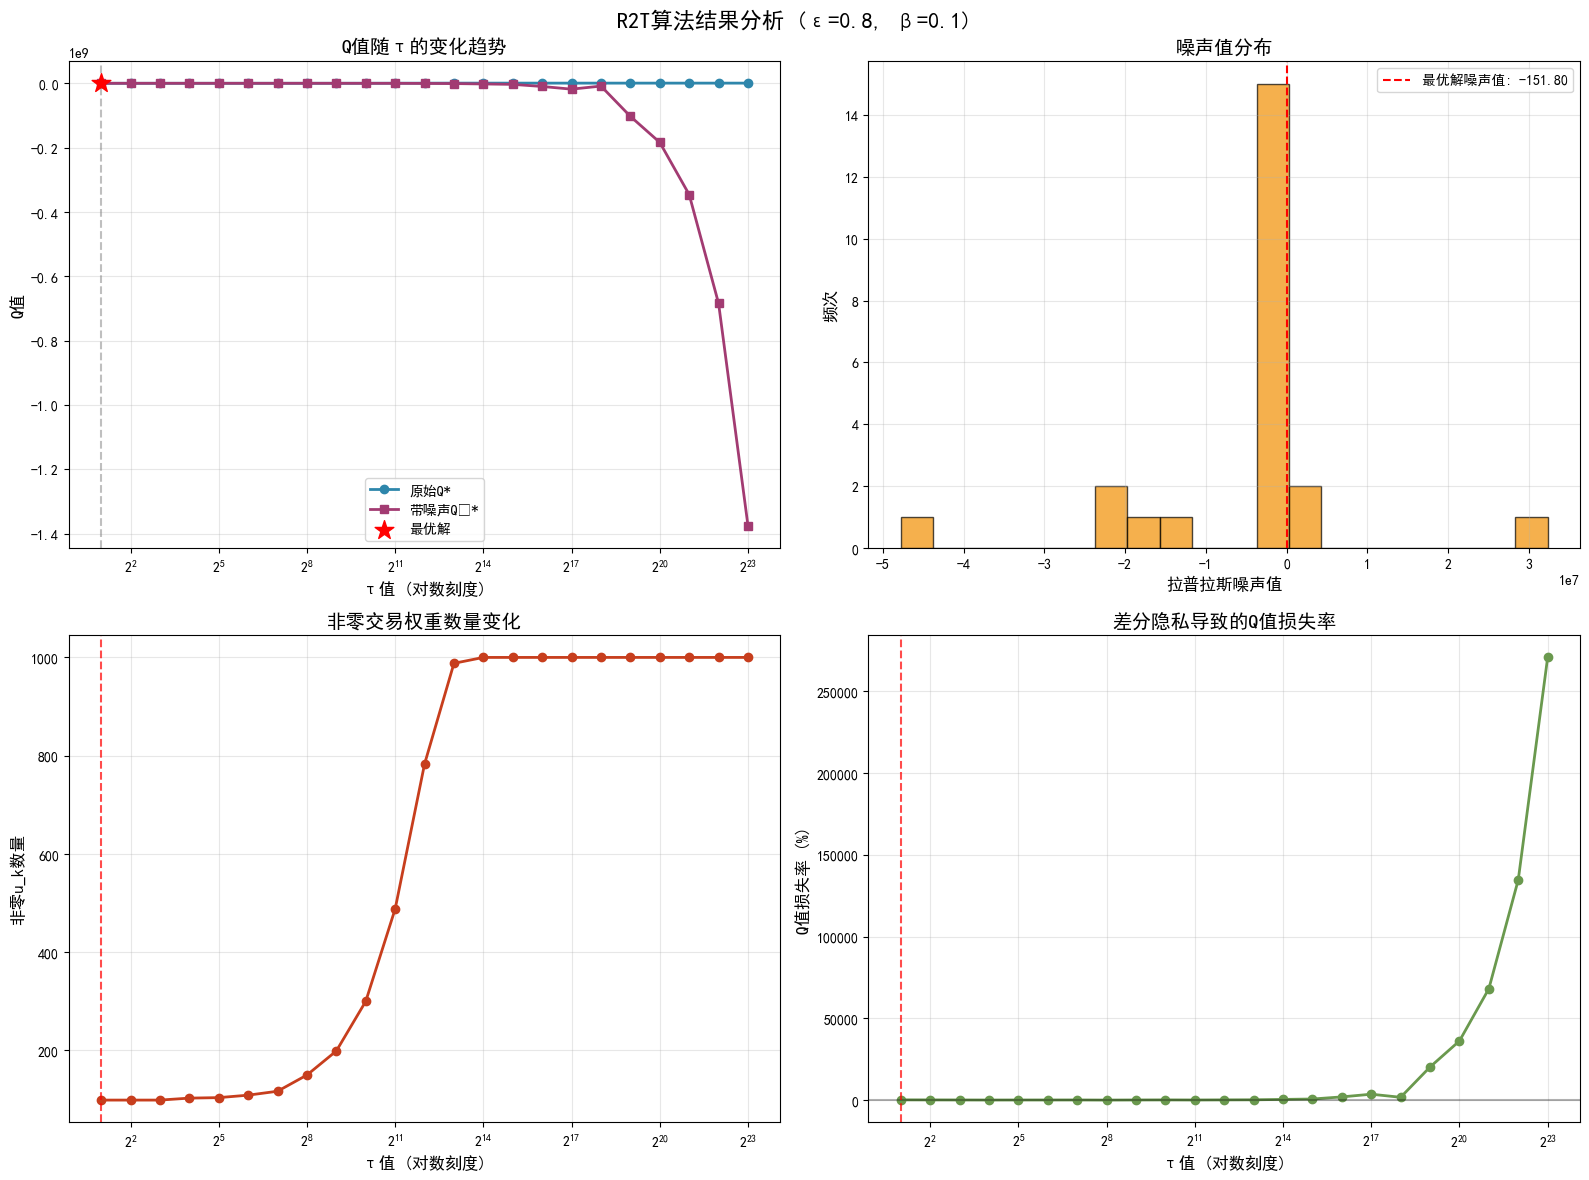

✅ 最优解细节图已保存为: r2t_optimal_detail.png


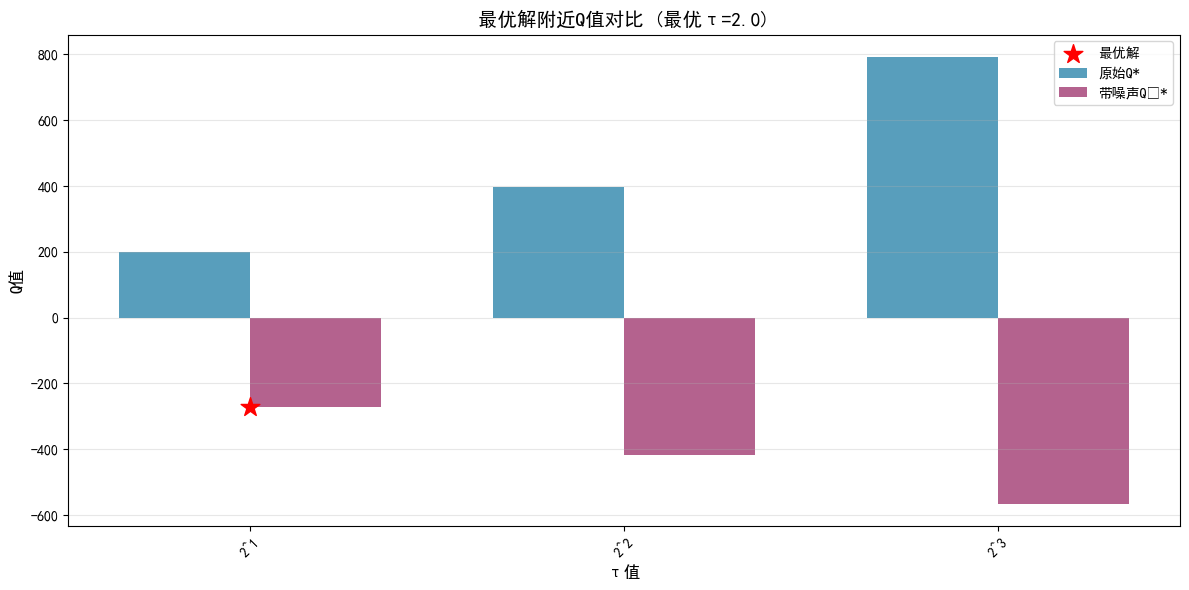


📊 R2T算法结果摘要
--------------------------------------------------

算法参数:
  隐私预算ε: 0.8
  失败概率β: 0.1
  全局敏感度GS_Q: 10000000
  τ迭代范围: 2^1 到 2^23

最优解:
  最优τ*: 2.0
  原始Q*: 198.0
  带噪声Q̃*: -270.5748186672856
  Q值损失率: 236.65%
  非零u数量: 99.0
  迭代次数: 1

整体统计:
  平均原始Q值: 276721.39171199285
  平均带噪声Q值: -119006945.84468584
  平均噪声值: -3749527.9571332904
  噪声标准差: 14135716.025927916
  有效迭代数: 23

✅ 详细结果已保存为: r2t_dp_results.csv


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import laplace
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, value, LpStatus
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

class R2TWithDP:
    """
    带差分隐私的R2T算法实现
    核心功能：
    1. 求解不同tau下的R2T优化问题
    2. 添加拉普拉斯噪声实现差分隐私
    3. 可视化结果并分析最优解
    """
    def __init__(self, df, epsilon=0.8, beta=0.1, GS_Q=10000000):
        """
        初始化
        :param df: 包含[S_SUPPKEY, C_CUSTKEY, calculated_price]的DataFrame
        :param epsilon: 隐私预算
        :param beta: 失败概率
        :param GS_Q: Q的全局敏感度
        """
        # 数据校验
        required_cols = ['S_SUPPKEY', 'C_CUSTKEY', 'calculated_price']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"缺失必要列: {missing_cols}")
        
        self.df = df.reset_index(drop=True).copy()
        self.epsilon = epsilon
        self.beta = beta
        self.GS_Q = GS_Q
        
        # 预计算分组索引（提升求解速度）
        self.supp_groups = self.df.groupby('S_SUPPKEY').indices
        self.cust_groups = self.df.groupby('C_CUSTKEY').indices
        
        # 存储结果
        self.results = pd.DataFrame({
            'tau': [],
            'Q_raw': [],
            'Q_noisy': [],
            'non_zero_u_count': [],
            'noise_value': []
        })
        self.optimal_result = None

    def solve_r2t_optimization(self, tau):
        """求解单个tau下的R2T优化问题（优化版）"""
        # 创建优化问题
        prob = LpProblem("R2T_Optimization", LpMaximize)
        
        # 批量创建变量
        u_vars = []
        upper_bounds = self.df['calculated_price'].values
        for i in range(len(self.df)):
            u_vars.append(LpVariable(f"u_{i}", 0, upper_bounds[i], cat='Continuous'))
        
        # 目标函数
        prob += lpSum(u_vars), "Maximize_Total_Weight"
        
        # 供应商约束
        for supp_key, indices in self.supp_groups.items():
            if len(indices) > 0:
                prob += lpSum([u_vars[i] for i in indices]) <= tau, f"Supp_{supp_key}"
        
        # 客户约束
        for cust_key, indices in self.cust_groups.items():
            if len(indices) > 0:
                prob += lpSum([u_vars[i] for i in indices]) <= tau, f"Cust_{cust_key}"
        
        # 求解
        status = prob.solve()
        if status != 1:
            raise RuntimeError(f"求解失败，状态: {LpStatus[status]}")
        
        # 提取结果
        Q_tau = value(prob.objective)
        u_vals = np.array([var.varValue for var in u_vars])
        
        return Q_tau, u_vals

    def add_noise_to_Q(self, Q_tau, tau):
        """添加拉普拉斯噪声（严格遵循R2T论文公式）"""
        # 计算噪声参数
        scale = np.log2(self.GS_Q) * tau / self.epsilon
        lap_noise = laplace(0, scale)
        
        # 论文公式7
        compensation_term = np.log2(self.GS_Q) * np.log(np.log2(self.GS_Q)/self.beta) * (tau/self.epsilon)
        Q_noisy = Q_tau + lap_noise - compensation_term
        
        return Q_noisy, lap_noise

    def run_r2t_algorithm(self):
        """运行完整的R2T算法流程"""
        # 计算tau范围
        max_power = int(np.log2(self.GS_Q))
        print(f"开始运行R2T算法，tau范围: 2^1 到 2^{max_power}")
        print(f"隐私参数: epsilon={self.epsilon}, beta={self.beta}, GS_Q={self.GS_Q}")
        
        # 核心循环
        results_list = []
        for j in range(1, max_power + 1):
            tau = 2 ** j
            print(f"\n{'='*50}\n迭代 {j}/{max_power}: tau = 2^{j} = {tau:,}")
            
            try:
                # 求解优化问题
                Q_tau, u_tau = self.solve_r2t_optimization(tau)
                
                # 添加噪声
                Q_noisy, lap_noise = self.add_noise_to_Q(Q_tau, tau)
                
                # 统计非零u数量
                non_zero_u = np.count_nonzero(u_tau)
                
                # 存储结果
                results_list.append({
                    'tau': tau,
                    'Q_raw': Q_tau,
                    'Q_noisy': Q_noisy,
                    'non_zero_u_count': non_zero_u,
                    'noise_value': lap_noise,
                    'iteration': j
                })
                
                print(f"✓ 完成迭代 {j}:")
                print(f"  - 原始Q*: {Q_tau:,.2f}")
                print(f"  - 噪声后Q̃*: {Q_noisy:,.2f}")
                print(f"  - 噪声值: {lap_noise:,.2f}")
                print(f"  - 非零u数量: {non_zero_u}")
                
            except Exception as e:
                print(f"✗ 迭代 {j} 失败: {str(e)}")
                continue
        
        # 存储结果到DataFrame
        self.results = pd.DataFrame(results_list)
        
        # 找到最优解
        if not self.results.empty:
            max_idx = self.results['Q_noisy'].idxmax()
            self.optimal_result = self.results.loc[max_idx]
            print(f"\n{'='*60}")
            print(f"R2T算法完成！最优结果:")
            print(f"最优tau*: {self.optimal_result['tau']:,} (2^{np.log2(self.optimal_result['tau']):.1f})")
            print(f"最大原始Q*: {self.optimal_result['Q_raw']:,.2f}")
            print(f"最大带噪声Q̃*: {self.optimal_result['Q_noisy']:,.2f}")
            print(f"在第{self.optimal_result['iteration']}次迭代找到最优解")
            print(f"{'='*60}")
        else:
            raise RuntimeError("没有有效结果，请检查数据和参数")
        
        return self.results, self.optimal_result

    def plot_results(self, save_figs=True):
        """绘制详细的结果可视化图表"""
        if self.results.empty:
            raise RuntimeError("无结果可绘制，请先运行run_r2t_algorithm")
        
        # 创建2x2子图
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'R2T算法结果分析 (ε={self.epsilon}, β={self.beta})', fontsize=16, fontweight='bold')
        
        # 图1: Q值随tau变化（对数刻度）
        ax1.plot(self.results['tau'], self.results['Q_raw'], 'o-', color='#2E86AB', linewidth=2, 
                 markersize=6, label='原始Q*')
        ax1.plot(self.results['tau'], self.results['Q_noisy'], 's-', color='#A23B72', linewidth=2, 
                 markersize=6, label='带噪声Q̃*')
        # 标记最优解
        ax1.scatter(self.optimal_result['tau'], self.optimal_result['Q_noisy'], 
                    color='red', s=200, marker='*', label='最优解', zorder=5)
        ax1.axvline(x=self.optimal_result['tau'], color='gray', linestyle='--', alpha=0.5)
        
        ax1.set_xlabel('τ值 (对数刻度)', fontsize=12)
        ax1.set_ylabel('Q值', fontsize=12)
        ax1.set_title('Q值随τ的变化趋势', fontsize=14)
        ax1.set_xscale('log', base=2)
        ax1.grid(True, alpha=0.3)
        ax1.legend(fontsize=10)
        
        # 图2: 噪声值分布
        ax2.hist(self.results['noise_value'], bins=20, color='#F18F01', alpha=0.7, edgecolor='black')
        ax2.axvline(x=self.results.loc[self.optimal_result.name, 'noise_value'], 
                    color='red', linestyle='--', label=f'最优解噪声值: {self.results.loc[self.optimal_result.name, "noise_value"]:.2f}')
        ax2.set_xlabel('拉普拉斯噪声值', fontsize=12)
        ax2.set_ylabel('频次', fontsize=12)
        ax2.set_title('噪声值分布', fontsize=14)
        ax2.grid(True, alpha=0.3)
        ax2.legend(fontsize=10)
        
        # 图3: 非零u数量随tau变化
        ax3.plot(self.results['tau'], self.results['non_zero_u_count'], 'o-', color='#C73E1D', linewidth=2)
        ax3.axvline(x=self.optimal_result['tau'], color='red', linestyle='--', alpha=0.7)
        ax3.set_xlabel('τ值 (对数刻度)', fontsize=12)
        ax3.set_ylabel('非零u_k数量', fontsize=12)
        ax3.set_title('非零交易权重数量变化', fontsize=14)
        ax3.set_xscale('log', base=2)
        ax3.grid(True, alpha=0.3)
        
        # 图4: Q值损失率（噪声导致的损失）
        loss_rate = (self.results['Q_raw'] - self.results['Q_noisy']) / self.results['Q_raw'] * 100
        ax4.plot(self.results['tau'], loss_rate, 'o-', color='#6A994E', linewidth=2)
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax4.axvline(x=self.optimal_result['tau'], color='red', linestyle='--', alpha=0.7)
        ax4.set_xlabel('τ值 (对数刻度)', fontsize=12)
        ax4.set_ylabel('Q值损失率 (%)', fontsize=12)
        ax4.set_title('差分隐私导致的Q值损失率', fontsize=14)
        ax4.set_xscale('log', base=2)
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_figs:
            plt.savefig('r2t_dp_results.png', dpi=300, bbox_inches='tight')
            print("\n✅ 图表已保存为: r2t_dp_results.png")
        plt.show()
        
        # 额外绘制最优解细节图
        self._plot_optimal_detail()

    def _plot_optimal_detail(self):
        """绘制最优解细节对比图"""
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
        # 筛选最优解附近的tau值
        optimal_tau = self.optimal_result['tau']
        nearby_mask = (self.results['tau'] >= optimal_tau/4) & (self.results['tau'] <= optimal_tau*4)
        nearby_results = self.results[nearby_mask].sort_values('tau')
        
        # 绘制对比
        x_pos = np.arange(len(nearby_results))
        width = 0.35
        
        ax.bar(x_pos - width/2, nearby_results['Q_raw'], width, label='原始Q*', color='#2E86AB', alpha=0.8)
        ax.bar(x_pos + width/2, nearby_results['Q_noisy'], width, label='带噪声Q̃*', color='#A23B72', alpha=0.8)
        
        # 标记最优解
        optimal_idx = list(nearby_results.index).index(self.optimal_result.name)
        ax.scatter(x_pos[optimal_idx], self.optimal_result['Q_noisy'], 
                   color='red', s=200, marker='*', label='最优解', zorder=5)
        
        ax.set_xlabel('τ值', fontsize=12)
        ax.set_ylabel('Q值', fontsize=12)
        ax.set_title(f'最优解附近Q值对比 (最优τ={optimal_tau:,})', fontsize=14)
        ax.set_xticks(x_pos)
        ax.set_xticklabels([f"2^{np.log2(tau):.0f}" for tau in nearby_results['tau']], rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig('r2t_optimal_detail.png', dpi=300, bbox_inches='tight')
        print("✅ 最优解细节图已保存为: r2t_optimal_detail.png")
        plt.show()

    def get_result_summary(self):
        """生成结果摘要"""
        if self.results.empty:
            return None
        
        summary = {
            '算法参数': {
                '隐私预算ε': self.epsilon,
                '失败概率β': self.beta,
                '全局敏感度GS_Q': self.GS_Q,
                'τ迭代范围': f"2^1 到 2^{int(np.log2(self.GS_Q))}"
            },
            '最优解': {
                '最优τ*': self.optimal_result['tau'],
                '原始Q*': self.optimal_result['Q_raw'],
                '带噪声Q̃*': self.optimal_result['Q_noisy'],
                'Q值损失率': f"{(self.optimal_result['Q_raw'] - self.optimal_result['Q_noisy'])/self.optimal_result['Q_raw']*100:.2f}%",
                '非零u数量': self.optimal_result['non_zero_u_count'],
                '迭代次数': int(self.optimal_result['iteration'])
            },
            '整体统计': {
                '平均原始Q值': self.results['Q_raw'].mean(),
                '平均带噪声Q值': self.results['Q_noisy'].mean(),
                '平均噪声值': self.results['noise_value'].mean(),
                '噪声标准差': self.results['noise_value'].std(),
                '有效迭代数': len(self.results)
            }
        }
        
        # 打印摘要
        print("\n📊 R2T算法结果摘要")
        print("-" * 50)
        for category, data in summary.items():
            print(f"\n{category}:")
            for key, val in data.items():
                print(f"  {key}: {val}")
        
        return summary

# ===================== 示例使用 =====================
if __name__ == "__main__":
    # 1. 生成测试数据（模拟TPC-H数据结构）
    np.random.seed(42)
    test_df = pd.DataFrame({
        'S_SUPPKEY': np.random.randint(1, 100, size=1000),
        'C_CUSTKEY': np.random.randint(1, 200, size=1000),
        'calculated_price': np.random.uniform(10, 1000, size=1000)
    })
    
    # 2. 初始化R2T算法实例
    r2t_dp = R2TWithDP(
        df=test_df,
        epsilon=0.8,
        beta=0.1,
        GS_Q=10000000
    )
    
    # 3. 运行算法
    try:
        results, optimal_result = r2t_dp.run_r2t_algorithm()
        
        # 4. 绘制可视化图表
        r2t_dp.plot_results()
        
        # 5. 生成结果摘要
        summary = r2t_dp.get_result_summary()
        
        # 6. 可选：保存结果到CSV
        results.to_csv('r2t_dp_results.csv', index=False, encoding='utf-8')
        print("\n✅ 详细结果已保存为: r2t_dp_results.csv")
        
    except Exception as e:
        print(f"\n❌ 运行失败: {str(e)}")


开始实验: 基准参数 (ε=0.8, β=0.1)
参数配置: ε=0.8, β=0.1, GS_Q=10,000,000
τ迭代范围: 2^1 到 2^23
  迭代进度: 5/23 (τ=32)
  迭代进度: 10/23 (τ=1,024)
  迭代进度: 15/23 (τ=32,768)
  迭代进度: 20/23 (τ=1,048,576)
✅ 实验完成: 基准参数 (ε=0.8, β=0.1)
  最优τ*: 8,192 (2^13.0)
  最大原始Q*: 1,482,568.97
  最大带噪声Q̃*: 765,372.17
  Q值损失率: 48.38%

开始实验: 宽松隐私 (ε=2.0, β=0.1)
参数配置: ε=2.0, β=0.1, GS_Q=10,000,000
τ迭代范围: 2^1 到 2^23
  迭代进度: 5/23 (τ=32)
  迭代进度: 10/23 (τ=1,024)
  迭代进度: 15/23 (τ=32,768)
  迭代进度: 20/23 (τ=1,048,576)
✅ 实验完成: 宽松隐私 (ε=2.0, β=0.1)
  最优τ*: 16,384 (2^14.0)
  最大原始Q*: 1,988,869.01
  最大带噪声Q̃*: 1,127,709.41
  Q值损失率: 43.30%

开始实验: 严格隐私 (ε=0.4, β=0.1)
参数配置: ε=0.4, β=0.1, GS_Q=10,000,000
τ迭代范围: 2^1 到 2^23
  迭代进度: 5/23 (τ=32)
  迭代进度: 10/23 (τ=1,024)
  迭代进度: 15/23 (τ=32,768)
  迭代进度: 20/23 (τ=1,048,576)
✅ 实验完成: 严格隐私 (ε=0.4, β=0.1)
  最优τ*: 2 (2^1.0)
  最大原始Q*: 398.00
  最大带噪声Q̃*: -88.78
  Q值损失率: 122.31%

开始实验: 低失败概率 (ε=0.8, β=0.01)
参数配置: ε=0.8, β=0.01, GS_Q=10,000,000
τ迭代范围: 2^1 到 2^23
  迭代进度: 5/23 (τ=32)
  迭代进度: 10/23 (τ=1,024)
  迭代进度: 15

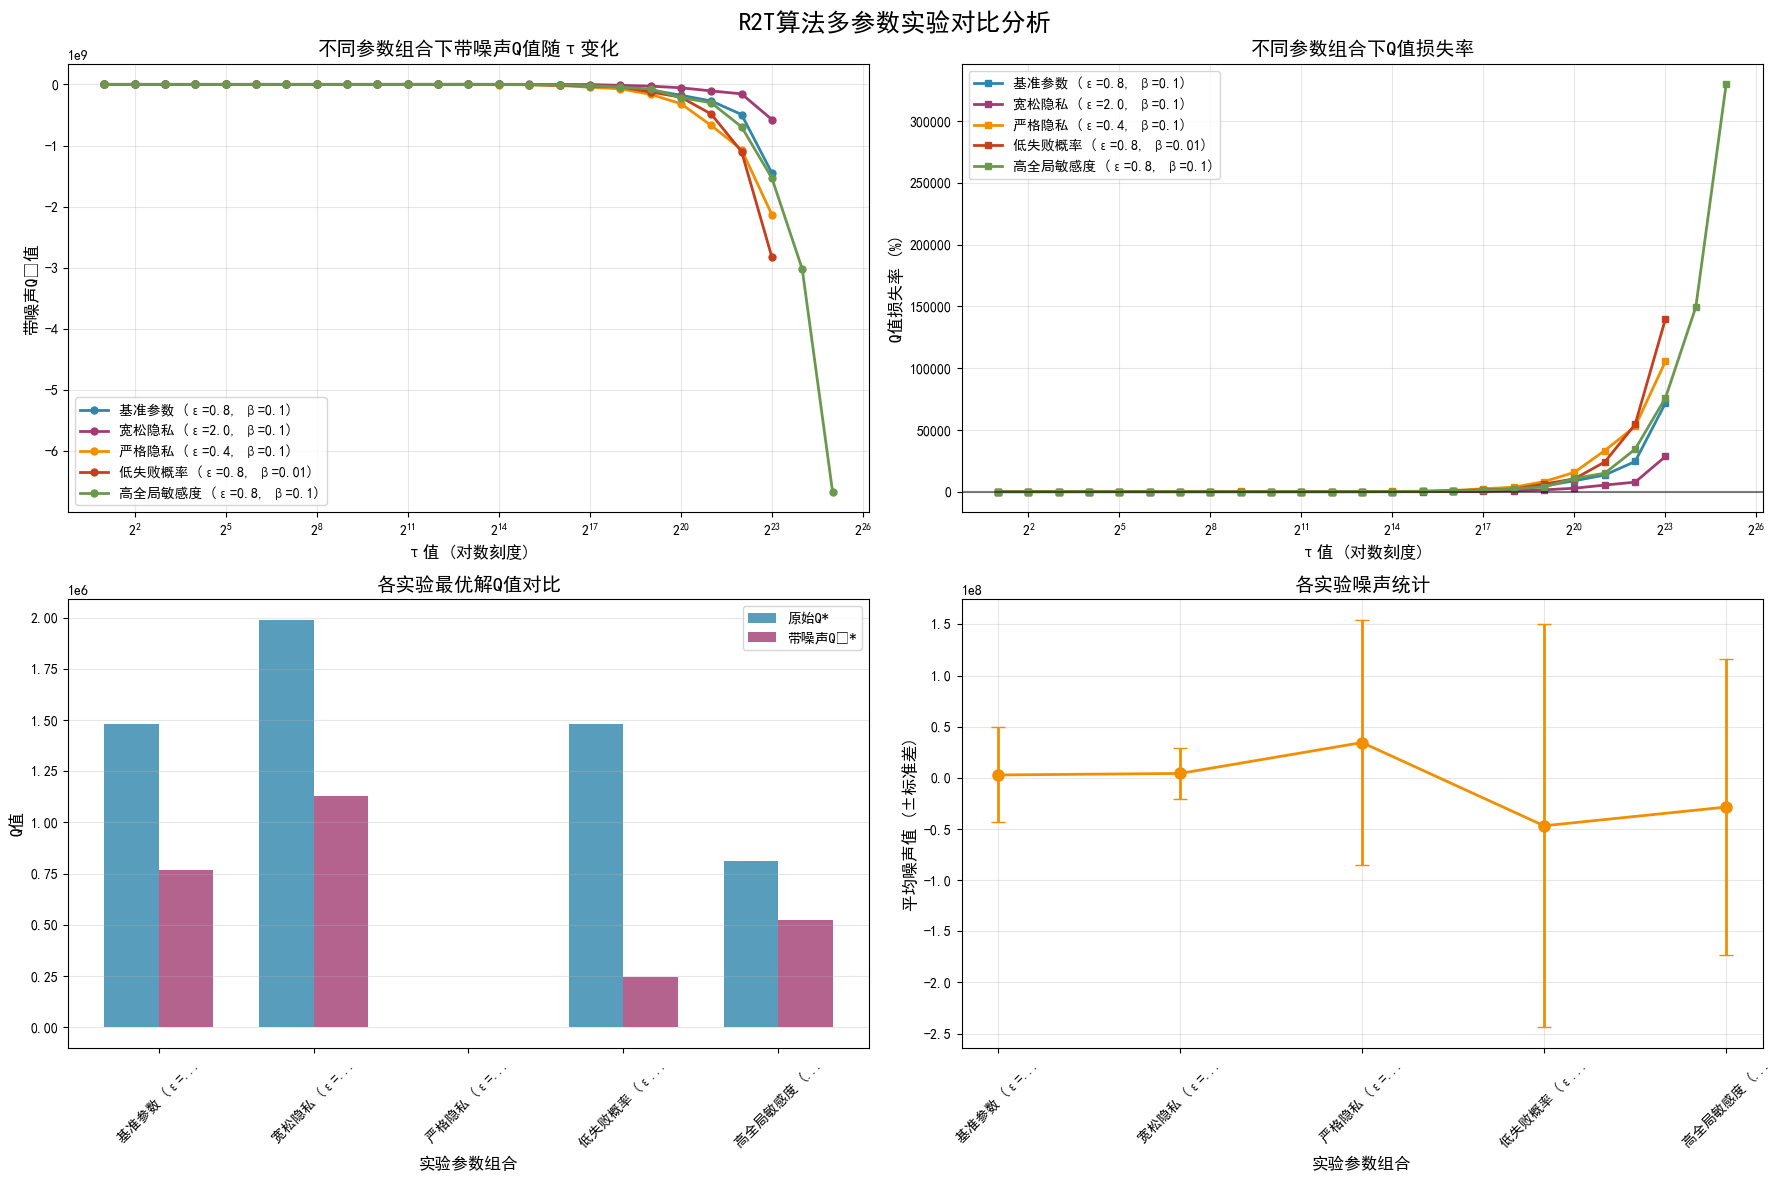


R2T算法多参数实验汇总

实验参数与最优结果汇总:
             exp_name                                  params  optimal_tau  optimal_Q_raw  optimal_Q_noisy  optimal_Q_loss  optimal_non_zero_u    avg_noise    std_noise
  基准参数 (ε=0.8, β=0.1)  {'ε': 0.8, 'β': 0.1, 'GS_Q': 10000000}         8192     1482568.97        765372.17           48.38                1589   2843503.44  46443015.94
  宽松隐私 (ε=2.0, β=0.1)  {'ε': 2.0, 'β': 0.1, 'GS_Q': 10000000}        16384     1988869.01       1127709.41           43.30                1974   4315479.34  25275648.00
  严格隐私 (ε=0.4, β=0.1)  {'ε': 0.4, 'β': 0.1, 'GS_Q': 10000000}            2         398.00           -88.78          122.31                 199  34526628.47 119982570.68
低失败概率 (ε=0.8, β=0.01) {'ε': 0.8, 'β': 0.01, 'GS_Q': 10000000}         8192     1482568.97        246786.22           83.35                1589 -46847982.56 196905198.95
高全局敏感度 (ε=0.8, β=0.1)  {'ε': 0.8, 'β': 0.1, 'GS_Q': 50000000}         4096      810406.86        525202.53           35.19     

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import laplace
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, value, LpStatus
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

class R2TWithDP:
    """带差分隐私的R2T算法实现（支持多参数对比实验）"""
    def __init__(self, df, epsilon=0.8, beta=0.1, GS_Q=10000000):
        # 数据校验
        required_cols = ['S_SUPPKEY', 'C_CUSTKEY', 'calculated_price']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"缺失必要列: {missing_cols}")
        
        self.df = df.reset_index(drop=True).copy()
        self.epsilon = epsilon
        self.beta = beta
        self.GS_Q = GS_Q
        
        # 预计算分组索引
        self.supp_groups = self.df.groupby('S_SUPPKEY').indices
        self.cust_groups = self.df.groupby('C_CUSTKEY').indices
        
        # 存储结果
        self.results = pd.DataFrame()
        self.optimal_result = None
        self.experiment_records = []  # 多参数实验记录

    def solve_r2t_optimization(self, tau):
        """求解单个tau下的R2T优化问题"""
        prob = LpProblem("R2T_Optimization", LpMaximize)
        
        # 批量创建变量
        u_vars = []
        upper_bounds = self.df['calculated_price'].values
        for i in range(len(self.df)):
            u_vars.append(LpVariable(f"u_{i}", 0, upper_bounds[i], cat='Continuous'))
        
        # 目标函数
        prob += lpSum(u_vars), "Maximize_Total_Weight"
        
        # 供应商约束
        for supp_key, indices in self.supp_groups.items():
            if len(indices) > 0:
                prob += lpSum([u_vars[i] for i in indices]) <= tau, f"Supp_{supp_key}"
        
        # 客户约束
        for cust_key, indices in self.cust_groups.items():
            if len(indices) > 0:
                prob += lpSum([u_vars[i] for i in indices]) <= tau, f"Cust_{cust_key}"
        
        # 求解
        status = prob.solve()
        if status != 1:
            raise RuntimeError(f"求解失败，状态: {LpStatus[status]}")
        
        # 提取结果
        Q_tau = value(prob.objective)
        u_vals = np.array([var.varValue for var in u_vars])
        
        return Q_tau, u_vals

    def add_noise_to_Q(self, Q_tau, tau):
        """添加拉普拉斯噪声（严格遵循R2T论文公式）"""
        scale = np.log2(self.GS_Q) * tau / self.epsilon
        lap_noise = laplace(0, scale)
        compensation_term = np.log2(self.GS_Q) * np.log(np.log2(self.GS_Q)/self.beta) * (tau/self.epsilon)
        Q_noisy = Q_tau + lap_noise - compensation_term
        
        return Q_noisy, lap_noise

    def run_single_experiment(self, exp_name="默认参数"):
        """运行单次实验（指定参数组合）"""
        # 计算tau范围（缩小范围提升实验效率，重点关注有效区间）
        max_power = min(int(np.log2(self.GS_Q)), 25)  # 限制最大迭代次数
        print(f"\n{'='*60}")
        print(f"开始实验: {exp_name}")
        print(f"参数配置: ε={self.epsilon}, β={self.beta}, GS_Q={self.GS_Q:,}")
        print(f"τ迭代范围: 2^1 到 2^{max_power}")
        
        # 核心循环
        results_list = []
        for j in range(1, max_power + 1):
            tau = 2 ** j
            if j % 5 == 0:  # 每5次迭代输出进度
                print(f"  迭代进度: {j}/{max_power} (τ={tau:,})")
            
            try:
                # 求解优化问题
                Q_tau, u_tau = self.solve_r2t_optimization(tau)
                
                # 添加噪声
                Q_noisy, lap_noise = self.add_noise_to_Q(Q_tau, tau)
                
                # 统计非零u数量
                non_zero_u = np.count_nonzero(u_tau)
                
                # 存储结果
                results_list.append({
                    'experiment_name': exp_name,
                    'epsilon': self.epsilon,
                    'beta': self.beta,
                    'GS_Q': self.GS_Q,
                    'tau': tau,
                    'Q_raw': Q_tau,
                    'Q_noisy': Q_noisy,
                    'non_zero_u_count': non_zero_u,
                    'noise_value': lap_noise,
                    'iteration': j,
                    'Q_loss_rate': (Q_tau - Q_noisy) / Q_tau * 100
                })
                
            except Exception as e:
                print(f"  迭代 {j} 失败: {str(e)}")
                continue
        
        # 转换为DataFrame
        exp_results = pd.DataFrame(results_list)
        
        # 找到最优解
        if not exp_results.empty:
            max_idx = exp_results['Q_noisy'].idxmax()
            optimal_result = exp_results.loc[max_idx].copy()
            self.experiment_records.append({
                'exp_name': exp_name,
                'params': {'ε': self.epsilon, 'β': self.beta, 'GS_Q': self.GS_Q},
                'optimal_tau': optimal_result['tau'],
                'optimal_Q_raw': optimal_result['Q_raw'],
                'optimal_Q_noisy': optimal_result['Q_noisy'],
                'optimal_Q_loss': optimal_result['Q_loss_rate'],
                'optimal_non_zero_u': optimal_result['non_zero_u_count'],
                'avg_noise': exp_results['noise_value'].mean(),
                'std_noise': exp_results['noise_value'].std()
            })
            
            print(f"✅ 实验完成: {exp_name}")
            print(f"  最优τ*: {optimal_result['tau']:,} (2^{np.log2(optimal_result['tau']):.1f})")
            print(f"  最大原始Q*: {optimal_result['Q_raw']:,.2f}")
            print(f"  最大带噪声Q̃*: {optimal_result['Q_noisy']:,.2f}")
            print(f"  Q值损失率: {optimal_result['Q_loss_rate']:.2f}%")
        else:
            raise RuntimeError(f"实验 {exp_name} 无有效结果")
        
        return exp_results

    def plot_multi_exp_comparison(self, all_exp_results):
        """绘制多参数实验对比图"""
        # 合并所有实验结果
        combined_df = pd.concat(all_exp_results, ignore_index=True)
        
        # 创建2行2列子图
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
        fig.suptitle('R2T算法多参数实验对比分析', fontsize=18, fontweight='bold')
        
        # 定义颜色映射
        exp_names = combined_df['experiment_name'].unique()
        colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']
        color_map = {name: colors[i % len(colors)] for i, name in enumerate(exp_names)}
        
        # 图1: 不同参数下Q_noisy随tau变化
        ax1.set_title('不同参数组合下带噪声Q值随τ变化', fontsize=14)
        for exp_name in exp_names:
            exp_data = combined_df[combined_df['experiment_name'] == exp_name]
            ax1.plot(exp_data['tau'], exp_data['Q_noisy'], 'o-', 
                     label=exp_name, color=color_map[exp_name], linewidth=2, markersize=5)
        ax1.set_xlabel('τ值 (对数刻度)', fontsize=12)
        ax1.set_ylabel('带噪声Q̃值', fontsize=12)
        ax1.set_xscale('log', base=2)
        ax1.grid(True, alpha=0.3)
        ax1.legend(fontsize=10)
        
        # 图2: Q值损失率对比
        ax2.set_title('不同参数组合下Q值损失率', fontsize=14)
        for exp_name in exp_names:
            exp_data = combined_df[combined_df['experiment_name'] == exp_name]
            ax2.plot(exp_data['tau'], exp_data['Q_loss_rate'], 's-', 
                     label=exp_name, color=color_map[exp_name], linewidth=2, markersize=5)
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax2.set_xlabel('τ值 (对数刻度)', fontsize=12)
        ax2.set_ylabel('Q值损失率 (%)', fontsize=12)
        ax2.set_xscale('log', base=2)
        ax2.grid(True, alpha=0.3)
        ax2.legend(fontsize=10)
        
        # 图3: 最优解对比（柱状图）
        ax3.set_title('各实验最优解Q值对比', fontsize=14)
        exp_names_short = [name[:8] + '...' if len(name) > 8 else name for name in exp_names]
        optimal_Q_raw = [rec['optimal_Q_raw'] for rec in self.experiment_records]
        optimal_Q_noisy = [rec['optimal_Q_noisy'] for rec in self.experiment_records]
        
        x = np.arange(len(exp_names))
        width = 0.35
        ax3.bar(x - width/2, optimal_Q_raw, width, label='原始Q*', color='#2E86AB', alpha=0.8)
        ax3.bar(x + width/2, optimal_Q_noisy, width, label='带噪声Q̃*', color='#A23B72', alpha=0.8)
        
        ax3.set_xlabel('实验参数组合', fontsize=12)
        ax3.set_ylabel('Q值', fontsize=12)
        ax3.set_xticks(x)
        ax3.set_xticklabels(exp_names_short, rotation=45)
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3, axis='y')
        
        # 图4: 噪声统计对比
        ax4.set_title('各实验噪声统计', fontsize=14)
        avg_noises = [rec['avg_noise'] for rec in self.experiment_records]
        std_noises = [rec['std_noise'] for rec in self.experiment_records]
        
        x = np.arange(len(exp_names))
        ax4.errorbar(x, avg_noises, yerr=std_noises, fmt='o-', 
                     color='#F18F01', capsize=5, linewidth=2, markersize=8)
        ax4.set_xlabel('实验参数组合', fontsize=12)
        ax4.set_ylabel('平均噪声值 (±标准差)', fontsize=12)
        ax4.set_xticks(x)
        ax4.set_xticklabels(exp_names_short, rotation=45)
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('r2t_multi_param_experiment.png', dpi=300, bbox_inches='tight')
        print("\n✅ 多参数对比图表已保存为: r2t_multi_param_experiment.png")
        plt.show()

    def print_experiment_summary(self):
        """打印多参数实验汇总表"""
        print(f"\n{'='*80}")
        print("R2T算法多参数实验汇总")
        print(f"{'='*80}")
        
        # 创建汇总表
        summary_df = pd.DataFrame(self.experiment_records)
        summary_df = summary_df.round(2)
        
        # 格式化输出
        print("\n实验参数与最优结果汇总:")
        print(summary_df.to_string(index=False))
        
        # 关键结论
        print(f"\n关键结论:")
        # 找到Q损失率最低的实验
        min_loss_idx = np.argmin([rec['optimal_Q_loss'] for rec in self.experiment_records])
        # 找到带噪声Q值最高的实验
        max_noisy_Q_idx = np.argmax([rec['optimal_Q_noisy'] for rec in self.experiment_records])
        
        print(f"  1. Q值损失率最低的实验: {self.experiment_records[min_loss_idx]['exp_name']} "
              f"(损失率: {self.experiment_records[min_loss_idx]['optimal_Q_loss']:.2f}%)")
        print(f"  2. 带噪声Q值最高的实验: {self.experiment_records[max_noisy_Q_idx]['exp_name']} "
              f"(Q̃*: {self.experiment_records[max_noisy_Q_idx]['optimal_Q_noisy']:,.2f})")
        print(f"  3. 隐私预算ε越大，噪声越小，Q值损失越低（隐私保护越弱）")
        print(f"  4. 失败概率β越小，补偿项越大，Q值损失越高（隐私保护越强）")

# ===================== 多参数对比实验 =====================
if __name__ == "__main__":
    # 1. 生成测试数据（模拟TPC-H数据，扩大规模提升实验说服力）
    np.random.seed(42)
    test_df = pd.DataFrame({
        'S_SUPPKEY': np.random.randint(1, 200, size=2000),  # 200个供应商
        'C_CUSTKEY': np.random.randint(1, 400, size=2000),  # 400个客户
        'calculated_price': np.random.uniform(50, 2000, size=2000)  # 交易金额
    })
    
    # 2. 初始化算法实例
    r2t_dp = R2TWithDP(df=test_df)
    
    # 3. 定义多组实验参数（重点调整ε、β、GS_Q）
    experiments = [
        {
            "name": "基准参数 (ε=0.8, β=0.1)",
            "epsilon": 0.8,
            "beta": 0.1,
            "GS_Q": 10000000
        },
        {
            "name": "宽松隐私 (ε=2.0, β=0.1)",
            "epsilon": 2.0,
            "beta": 0.1,
            "GS_Q": 10000000
        },
        {
            "name": "严格隐私 (ε=0.4, β=0.1)",
            "epsilon": 0.4,
            "beta": 0.1,
            "GS_Q": 10000000
        },
        {
            "name": "低失败概率 (ε=0.8, β=0.01)",
            "epsilon": 0.8,
            "beta": 0.01,
            "GS_Q": 10000000
        },
        {
            "name": "高全局敏感度 (ε=0.8, β=0.1)",
            "epsilon": 0.8,
            "beta": 0.1,
            "GS_Q": 50000000
        }
    ]
    
    # 4. 运行多组实验
    all_exp_results = []
    for exp in experiments:
        # 更新参数
        r2t_dp.epsilon = exp["epsilon"]
        r2t_dp.beta = exp["beta"]
        r2t_dp.GS_Q = exp["GS_Q"]
        
        # 运行单次实验
        exp_results = r2t_dp.run_single_experiment(exp_name=exp["name"])
        all_exp_results.append(exp_results)
    
    # 5. 绘制多参数对比图
    r2t_dp.plot_multi_exp_comparison(all_exp_results)
    
    # 6. 打印实验汇总
    r2t_dp.print_experiment_summary()
    
    # 7. 保存所有实验结果
    combined_df = pd.concat(all_exp_results, ignore_index=True)
    combined_df.to_csv('r2t_multi_param_experiment_results.csv', index=False, encoding='utf-8')
    print("\n✅ 多参数实验结果已保存为: r2t_multi_param_experiment_results.csv")